Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# Automated Machine Learning
_**Energy Demand Forecasting**_

## Contents
1. [Introduction](#Introduction)
2. [Setup](#Setup)
3. [Data](#Data)
4. [Train](#Train)
5. [Deploy](#Deploy)

## Introduction
In this example, we show how AutoML can be used for energy demand forecasting.

Make sure you have executed the [configuration](../../../configuration.ipynb) before running this notebook.

In this notebook you would see
1. Creating an Experiment in an existing Workspace
2. Instantiating AutoMLConfig with new task type "forecasting" for timeseries data training, and other timeseries related settings: for this dataset we use the basic one: "time_column_name" 
3. Training the Model using local compute
4. Exploring the results
5. Testing the fitted model

# Scenario
This scenario focuses on energy demand forecasting where the __goal is to predict the future load on an energy grid__. It is a critical business operation for companies in the energy sector as operators need to maintain the fine balance between the energy consumed on a grid and the energy supplied to it. 

Too much power supplied to the grid can result in waste of energy or technical faults. However, if too little power is supplied it can lead to blackouts, leaving customers without power. ypically, grid operators can take short-term decisions to manage energy supply to the grid and keep the load in balance. An accurate short-term forecast of energy demand is therefore essential for the operator to make these decisions with confidence.

This scenario details the construction of a machine learning energy demand forecasting solution. _The solution is trained on a public dataset from the New York Independent System Operator (NYISO)_ , which operates the power grid for New York State. 
The dataset includes hourly power demand data for New York City over a period of five years. An additional dataset containing hourly weather conditions in New York City over the same time period was taken from darksky.net. 


## Setup

As part of the setup you have already created a <b>Workspace</b>. For AutoML you would need to create an <b>Experiment</b>. An <b>Experiment</b> is a named object in a <b>Workspace</b>, which is used to run experiments.

In [1]:
# Import libraries
import azureml.core
import pandas as pd
import numpy as np
import logging
import warnings
# Squash warning messages for cleaner output in the notebook
warnings.showwarning = lambda *args, **kwargs: None


from azureml.core.workspace import Workspace
from azureml.core.experiment import Experiment
from azureml.train.automl import AutoMLConfig
from azureml.train.automl.run import AutoMLRun
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# Retrieve workspace
ws = Workspace.from_config()

# choose a name for the run history container in the workspace
experiment_name = 'automl-energydemandforecasting'
# project folder
project_folder = './sample_projects/automl-local-energydemandforecasting'

experiment = Experiment(ws, experiment_name)

output = {}
output['SDK version'] = azureml.core.VERSION
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Project Directory'] = project_folder
output['Run History Name'] = experiment_name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

If you run your code in unattended mode, i.e., where you can't give a user input, then we recommend to use ServicePrincipalAuthentication or MsiAuthentication.
Please refer to aka.ms/aml-notebook-auth for different authentication mechanisms in azureml-sdk.


Found the config file in: /home/nbuser/library/Module_2_Get Started with AzureML/aml_config/config.json
Performing interactive authentication. Please follow the instructions on the terminal.
To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code FL9NWJG9U to authenticate.
Interactive authentication successfully completed.


,
Location,eastus
Project Directory,./sample_projects/automl-local-energydemandforecasting
Resource Group,aiconfnyc
Run History Name,automl-energydemandforecasting
SDK version,1.0.17
Subscription ID,5d9f0467-1e93-45cb-9531-b2f8e715feb1
Workspace,aiconfnycws


## Data
Read energy demanding data from file, and preview data.

In [3]:
data = pd.read_csv("nyc_energy.csv", parse_dates=['timeStamp'])
data.head()

,timeStamp,demand,precip,temp
0,2012-01-01 00:00:00,4937.50,0.00,46.13
1,2012-01-01 01:00:00,4752.10,0.00,45.89
2,2012-01-01 02:00:00,4542.60,0.00,45.04
3,2012-01-01 03:00:00,4357.70,0.00,45.03
4,2012-01-01 04:00:00,4275.50,0.00,42.61


### Split the data to train and test



In [4]:
train = data[data['timeStamp'] < '2017-02-01']
test = data[data['timeStamp'] >= '2017-02-01']


### Prepare the test data, we will feed X_test to the fitted model and get prediction

In [5]:
y_test = test.pop('demand').values
X_test = test

### Split the train data to train and valid

Use one month's data as valid data


In [6]:
X_train = train[train['timeStamp'] < '2017-01-01']
X_valid = train[train['timeStamp'] >= '2017-01-01']
y_train = X_train.pop('demand').values
y_valid = X_valid.pop('demand').values
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(43847, 3)
(43847,)
(744, 3)
(744,)


## Train

Instantiate a AutoMLConfig object. This defines the settings and data used to run the experiment.

Read more in the [documentation](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-configure-auto-train)

In [7]:
# Set the time series column
time_column_name = 'timeStamp'
automl_settings = {
    "time_column_name": time_column_name,
}

# create the configuration object
automl_config = AutoMLConfig(task = 'forecasting',
                             debug_log = 'automl_nyc_energy_errors.log',
                             primary_metric='normalized_root_mean_squared_error',
                             iterations = 5,
                             iteration_timeout_minutes = 10,
                             X = X_train,
                             y = y_train,
                             X_valid = X_valid,
                             y_valid = y_valid,
                             path=project_folder,
                             blacklist_models = ['RandomForest'],
                             # model_explainability=True,
                             verbosity = logging.INFO,
                            **automl_settings)

You can call the submit method on the experiment object and pass the run configuration. For Local runs the execution is synchronous. Depending on the data and number of iterations this can run for while.
You will see the currently running iterations printing to the console.

In [8]:
local_run = experiment.submit(automl_config, show_output=True)

Running on local machine
Parent Run ID: AutoML_4625d0b7-d776-497a-bbed-e5a6b285ddaf
********************************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
SAMPLING %: Percent of the training data to sample.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
********************************************************************************************************************

 ITERATION   PIPELINE                                       SAMPLING %  DURATION      METRIC      BEST
         0   StandardScalerWrapper ElasticNet               100.0000    0:00:21       0.0819    0.0819
         1   StandardScalerWrapper ElasticNet               100.0000    0:00:15       0.0814    0.0814
         2   StandardScalerWrapper ElasticNet               100

In [9]:
# View the run summary
local_run

Experiment,Id,Type,Status,Details Page,Docs Page
automl-energydemandforecasting,AutoML_4625d0b7-d776-497a-bbed-e5a6b285ddaf,automl,Completed,Link to Azure Portal,Link to Documentation


### Retrieve the Best Model
Below we select the best pipeline from our iterations. The get_output method on automl_classifier returns the best run and the fitted model for the last fit invocation. There are overloads on get_output that allow you to retrieve the best run and fitted model for any logged metric or a particular iteration.

In [10]:
best_run, fitted_model = local_run.get_output()
fitted_model.steps

[('timeseriestransformer', TimeSeriesTransformer(logger=None)),
 ('standardscalerwrapper',
  <automl.client.core.common.model_wrappers.StandardScalerWrapper at 0x7f5f20f39b00>),
 ('elasticnet',
  ElasticNet(alpha=0.15873684210526315, copy_X=True, fit_intercept=True,
        l1_ratio=0.6873684210526316, max_iter=1000, normalize=False,
        positive=False, precompute=False, random_state=None,
        selection='cyclic', tol=0.0001, warm_start=False))]

### Retrieve explanation for best model


In [11]:
from azureml.train.automl.automlexplainer import explain_model

# shap_values, expected_values, overall_summary, overall_imp, per_class_summary, per_class_imp = \
#    explain_model(fitted_model, X_train, X_test, best_run)

### Widget for monitoring runs

In [13]:
!pip install azureml-widgets

In [14]:
from azureml.widgets import RunDetails
RunDetails(local_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

### Test the Best Fitted Model

Predict on training and test set, and calculate residual values.

In [15]:
y_pred = fitted_model.predict(X_test)
y_pred

array([4956.74546589, 5052.91719952, 5141.45221388, ..., 6132.78185879,
       6156.08656278, 6182.57560686])

### Use the Check Data Function to remove the nan values from y_test to avoid error when calculate metrics 

In [16]:
if len(y_test) != len(y_pred):
    raise ValueError(
        'the true values and prediction values do not have equal length.')
elif len(y_test) == 0:
    raise ValueError(
        'y_true and y_pred are empty.')

# if there is any non-numeric element in the y_true or y_pred,
# the ValueError exception will be thrown.
y_test_f = np.array(y_test).astype(float)
y_pred_f = np.array(y_pred).astype(float)

# remove entries both in y_true and y_pred where at least
# one element in y_true or y_pred is missing
y_test = y_test_f[~(np.isnan(y_test_f) | np.isnan(y_pred_f))]
y_pred = y_pred_f[~(np.isnan(y_test_f) | np.isnan(y_pred_f))]

### Plot the predictions to compare to actual data

[Test Data] 
Root Mean squared error: 879.91
mean_absolute_error score: 708.97
R2 score: 0.54


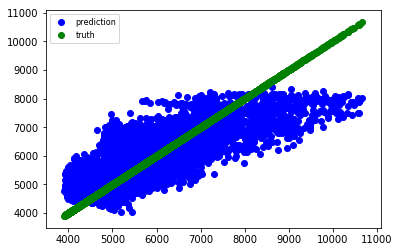

In [17]:
print("[Test Data] \nRoot Mean squared error: %.2f" % np.sqrt(mean_squared_error(y_test, y_pred)))
# Explained variance score: 1 is perfect prediction
print('mean_absolute_error score: %.2f' % mean_absolute_error(y_test, y_pred))
print('R2 score: %.2f' % r2_score(y_test, y_pred))

# Plot outputs
test_pred = plt.scatter(y_test, y_pred, color='b')
test_test = plt.scatter(y_test, y_test, color='g')
plt.legend((test_pred, test_test), ('prediction', 'truth'), loc='upper left', fontsize=8)
plt.show()

## Deploy
Deploy the model into an Azure Container Instance to enable inferencing on new data

### Register the model
Register the best model to the AML service

In [18]:
model = local_run.register_model(description = 'automated ml model for energy demand forecasting', tags = {'ml': "Forecasting", 'type': "automl"})
print(local_run.model_id) # This will be written to the script file later in the notebook.

Registering model AutoML4625d0b7dbest
AutoML4625d0b7dbest


### Create Scoring Script
This will be used to run the model on new data for predictions

In [19]:
%%writefile score_energy_demand.py
import pickle
import json
import numpy as np
import azureml.train.automl
from sklearn.externals import joblib
from azureml.core.model import Model


def init():
    global model
    model_path = Model.get_model_path(model_name = '<<modelid>>') # this name is model.id of model that we want to deploy
    # deserialize the model file back into a sklearn model
    model = joblib.load(model_path)

def run(timestamp,precip,temp):
    try:
        rawdata = json.dumps({timestamp, precip, temp})
        data = json.loads(rawdata)
        data_arr = numpy.array(data)
        result = model.predict(data_arr)
        # result = json.dumps({'timeStamp':timestamp, 'precip':precip, 'temp':temp})
    except Exception as e:
        result = str(e)
        return json.dumps({"error": result})
    return json.dumps({"result":result.tolist()})

Overwriting score_energy_demand.py


### Create a YAML File for the Environment
the YAML file will be used to setup the conda environment on the deployed image

In [20]:
# Retrieve the dependencies
experiment = Experiment(ws, experiment_name)
ml_run = AutoMLRun(experiment = experiment, run_id = local_run.id)
dependencies = ml_run.get_run_sdk_dependencies(iteration = 0)
for p in ['azureml-train-automl', 'azureml-sdk', 'azureml-core']:
    print('{}\t{}'.format(p, dependencies[p]))

No issues found in the SDK package versions.
azureml-train-automl	1.0.17.1
azureml-sdk	1.0.17
azureml-core	1.0.17.1


In [21]:
# Create the environment file

from azureml.core.conda_dependencies import CondaDependencies 

myenv = CondaDependencies.create(conda_packages=['numpy','scikit-learn'], pip_packages=["azureml-train-automl"])
print(myenv.serialize_to_string())

conda_env_file_name = 'my_conda_env.yml'
myenv.save_to_file('.', conda_env_file_name)

# Conda environment specification. The dependencies defined in this file will
# be automatically provisioned for runs with userManagedDependencies=False.

# Details about the Conda environment file format:
# https://conda.io/docs/user-guide/tasks/manage-environments.html#create-env-file-manually

name: project_environment
dependencies:
  # The python interpreter version.
  # Currently Azure ML only supports 3.5.2 and later.
- python=3.6.2

- pip:
  - azureml-train-automl==1.0.17
- numpy
- scikit-learn



'my_conda_env.yml'

In [22]:
# Substitute the actual version number in the environment file.
# This is not strictly needed in this notebook because the model should have been generated using the current SDK version.
# However, we include this in case this code is used on an experiment from a previous SDK version.

with open(conda_env_file_name, 'r') as cefr:
    content = cefr.read()

with open(conda_env_file_name, 'w') as cefw:
    cefw.write(content.replace(azureml.core.VERSION, dependencies['azureml-sdk']))

# Substitute the actual model id in the script file.

script_file_name = 'score_energy_demand.py'

with open(script_file_name, 'r') as cefr:
    content = cefr.read()

with open(script_file_name, 'w') as cefw:
    cefw.write(content.replace('<<modelid>>', local_run.model_id))

### Generate schema file


In [23]:
!pip install --upgrade azureml-sdk[webservice-schema]

    100% |████████████████████████████████| 819kB 11.4MB/s ta 0:00:01
    100% |████████████████████████████████| 51kB 15.6MB/s ta 0:00:01
    100% |████████████████████████████████| 153kB 20.7MB/s ta 0:00:01


    100% |████████████████████████████████| 211.9MB 5.9kB/s eta 0:00:01 3% |█▎                              | 8.3MB 14.6MB/s eta 0:00:14    16% |█████▍                          | 35.4MB 28.7MB/s eta 0:00:07    32% |██████████▍                     | 68.7MB 19.4MB/s eta 0:00:08    40% |████████████▉                   | 85.0MB 1.1MB/s eta 0:01:52    43% |██████████████                  | 92.1MB 13.6MB/s eta 0:00:09    56% |██████████████████              | 119.8MB 12.5MB/s eta 0:00:08███████            | 132.3MB 12.1MB/s eta 0:00:07    66% |█████████████████████▏          | 139.9MB 16.0MB/s eta 0:00:05    73% |███████████████████████▌        | 155.4MB 12.1MB/s eta 0:00:05    76% |████████████████████████▋       | 162.8MB 10.2MB/s eta 0:00:05    91% |█████████████████████████████▍  | 194.6MB 10.2MB/s eta 0:00:02
    100% |████████████████████████████████| 204kB 20.5MB/s ta 0:00:01
  Stored in directory: /home/nbuser/.cache/pip/wheels/d1/6a/e7/529dc54d76ecede4346164a09ae3168df358945612710f5

    Uninstalling azureml-core-1.0.17.1:
      Successfully uninstalled azureml-core-1.0.17.1
  Found existing installation: azureml-train-restclients-hyperdrive 1.0.17
    Uninstalling azureml-train-restclients-hyperdrive-1.0.17:
      Successfully uninstalled azureml-train-restclients-hyperdrive-1.0.17
  Found existing installation: azureml-telemetry 1.0.17
    Uninstalling azureml-telemetry-1.0.17:
      Successfully uninstalled azureml-telemetry-1.0.17
  Found existing installation: azureml-train-core 1.0.17
    Uninstalling azureml-train-core-1.0.17:
      Successfully uninstalled azureml-train-core-1.0.17
  Found existing installation: azureml-train 1.0.17
    Uninstalling azureml-train-1.0.17:
      Successfully uninstalled azureml-train-1.0.17
  Found existing installation: azureml-pipeline-core 1.0.17
    Uninstalling azureml-pipeline-core-1.0.17:
      Successfully uninstalled azureml-pipeline-core-1.0.17
  Found existing installation: azureml-pipeline-steps 1.0.17
    Uninsta

In [24]:
from azureml.webservice_schema.sample_definition import SampleDefinition
from azureml.webservice_schema.data_types import DataTypes
from azureml.webservice_schema.schema_generation import generate_schema

schema_file_name = './schema.json'
def run(timestamp,precip,temp):
    return "OK"

import numpy as np
generate_schema(run, inputs={
    "timestamp" : SampleDefinition(DataTypes.STANDARD, '2012-01-01 00:00:00'),
    "precip" : SampleDefinition(DataTypes.STANDARD, '0.0'),
    "temp" : SampleDefinition(DataTypes.STANDARD, '0.0')}, 
    filepath=schema_file_name)

{'input': {'timestamp': {'internal': 'gANjYXp1cmVtbC53ZWJzZXJ2aWNlX3NjaGVtYS5fcHl0aG9uX3V0aWwKUHl0aG9uU2NoZW1hCnEAKYFxAX1xAlgJAAAAZGF0YV90eXBlcQNjYnVpbHRpbnMKc3RyCnEEc2Iu',
   'swagger': {'type': 'string', 'example': '2012-01-01 00:00:00'},
   'type': 0,
   'version': '1.0.23'},
  'precip': {'internal': 'gANjYXp1cmVtbC53ZWJzZXJ2aWNlX3NjaGVtYS5fcHl0aG9uX3V0aWwKUHl0aG9uU2NoZW1hCnEAKYFxAX1xAlgJAAAAZGF0YV90eXBlcQNjYnVpbHRpbnMKc3RyCnEEc2Iu',
   'swagger': {'type': 'string', 'example': '0.0'},
   'type': 0,
   'version': '1.0.23'},
  'temp': {'internal': 'gANjYXp1cmVtbC53ZWJzZXJ2aWNlX3NjaGVtYS5fcHl0aG9uX3V0aWwKUHl0aG9uU2NoZW1hCnEAKYFxAX1xAlgJAAAAZGF0YV90eXBlcQNjYnVpbHRpbnMKc3RyCnEEc2Iu',
   'swagger': {'type': 'string', 'example': '0.0'},
   'type': 0,
   'version': '1.0.23'}}}

### Create a Docker file to include extra dependencies in the image

In [25]:
%%writefile docker_steps.dockerfile
RUN apt-get update && \
    apt-get upgrade -y && \
    apt-get install -y build-essential gcc g++ python-dev unixodbc unixodbc-dev

Overwriting docker_steps.dockerfile


In [26]:
docker_file_name = "docker_steps.dockerfile"

### Create a Container Image
The container image will be based on the model and is used to deploy the container instance

In [27]:
from azureml.core.image import Image, ContainerImage

image_config = ContainerImage.image_configuration(runtime= "python",
                                 execution_script = script_file_name,
                                 docker_file = docker_file_name,
                                 schema_file = schema_file_name,
                                 conda_file = conda_env_file_name,
                                 tags = {'ml': "Forecasting", 'type': "automl"},
                                 description = "Image for automated ml energy demand forecasting predictions")

image = Image.create(name = "automlenergyforecasting",
                     models = [model],
                     image_config = image_config, 
                     workspace = ws)

image.wait_for_creation(show_output = True)

Creating image
Running......................................................................
SucceededImage creation operation finished for image automlenergyforecasting:2, operation "Succeeded"


### Deploy the Image as a Web Service on Azure Container Instance

In [28]:
from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores = 1, 
                                               memory_gb = 1, 
                                               tags = {'ml': "Forecasting", 'type': "automl"}, 
                                               description = 'ACI service for automated ml energy demand forecasting predictions')

In [31]:
from azureml.core.webservice import Webservice

aci_service_name = 'automlenergyforecasting'
print(aci_service_name)
aci_service = Webservice.deploy_from_image(deployment_config = aciconfig,
                                           image = image,
                                           name = aci_service_name,
                                           workspace = ws)
aci_service.wait_for_deployment(True)
print(aci_service.state)